# Homework 7

## Question 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

### 1. Is the timeseries of your stock/ETF stationary when you plot it over time? Why or why not can you determine this by simply looking at the plot?

In [2]:
stocks = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv', index_col=0, header=[0,1])
stocks.index = pd.to_datetime(stocks.index).to_period('B')
stocks.head()

Adj Close                                                 \
                 AAPL         GLD       MSFT         QQQ         SPY   
Date                                                                   
2018-01-02  40.722874  125.150002  80.229012  152.072800  243.072266   
2018-01-03  40.715786  124.820000  80.602394  153.550400  244.609711   
2018-01-04  40.904907  125.459999  81.311806  153.819046  245.640732   
2018-01-05  41.370617  125.330002  82.319908  155.363861  247.277679   
2018-01-08  41.216949  125.309998  82.403923  155.968399  247.729935   

                                      Close                         ...  \
                 TSLA        USO       AAPL         GLD       MSFT  ...   
Date                                                                ...   
2018-01-02  21.368668  96.559998  43.064999  125.150002  85.949997  ...   
2018-01-03  21.150000  98.720001  43.057499  124.820000  86.349998  ...   
2018-01-04  20.974667  98.959999  43.257500  125.459999  87.110001  ...   
2018-01-05  21.105333  98.480003  43.750000  125.330002  88.190002  ...   
2018-01-08  22.427334  99.040001  43.587502  125.309998  88.279999  ...   

                  Open                           Volume                      \
                   SPY       TSLA        USO       AAPL       GLD      MSFT   
Date                                                                          
2018-01-02  267.839996  20.799999  96.559998  102223600  11762500  22483800   
2018-01-03  268.959991  21.400000  97.360001  118071600   7904300  26061400   
2018-01-04  271.200012  20.858000  98.639999   89738400   7329700  21912000   
2018-01-05  272.510010  21.108000  98.239998   94640000   5739900  23407100   
2018-01-08  273.309998  21.066668  98.480003   82271200   3566700  22113000   

                                                    
                 QQQ       SPY       TSLA      USO  
Date                                                
2018-01-02  32573300  86655700   65283000  1497588  
2018-01-03  29383600  90070400   67822500  2156150  
2018-01-04  24776100  80636400  149194500  1480988  
2018-01-05  26992300  83524000   68868000  1609888  
2018-01-08  23159100  57319200  147891000  1229225  

[5 rows x 42 columns]

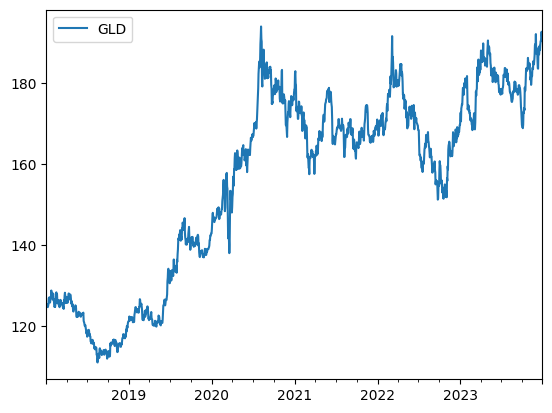

In [3]:
df = stocks['Close'][['GLD']]

idx = pd.period_range(min(df.index), max(df.index))
df = df.reindex(idx, fill_value=np.nan)
df = df.fillna(method = 'ffill')

df.plot()
plt.show()

1. (Answer) - No the timeseries is not stationary. Yes we can tell by looking at it because there is a clear upwards trend. There is not as clear seasonality, but the trend is enough to make it non-stationary.

### 2. Create a new column called "LogReturn" and add it to your data frame. LogReturn = Log(P2) - Log(P1)

In [4]:
df['LogReturn']= np.log(df['GLD']).diff(1)
df.dropna(inplace=True)
df.head()

,GLD,LogReturn
2018-01-03,124.820000,-0.002640
2018-01-04,125.459999,0.005114
2018-01-05,125.330002,-0.001037
2018-01-08,125.309998,-0.000160
2018-01-09,124.730003,-0.004639


### 3. Plot the log returns! are the log returns stationary?

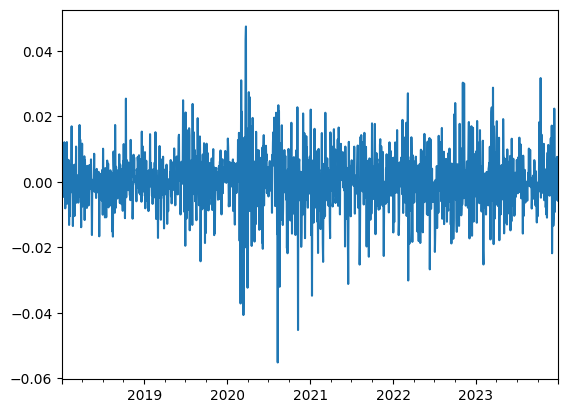

In [5]:
df['LogReturn'].plot()
plt.show()

3. (Answer) - The Log Returns do appear to be stationary, at least weakly. Variance is not constant, but I think it's close enough for us to work with.

### 4. Split your dataset into 60% train, 20% validation and the remaining data as test set.

In [6]:
num_train_samples = int(0.60 * len(df))
num_val_samples = int(0.20 * len(df))
num_test_samples = len(df) - num_train_samples - num_val_samples

### 5. Generate train, val and test dataset using timeseries_dataset_from_array() utility from Keras.

1. We are planning to use the past 60 days to predict the return on the next day. 
2. Use batch size = 32

In [7]:
series = df['LogReturn']
sequence_length = 60
h = 1
delay = sequence_length  + h - 1
batch_size = 32

train_dataset = timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

### 6. Create a naive forecaster (common-sense benchmark) and report the Validation and Test MAE. Our goal is to beat these metrics.

In [8]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 0.01
Test MAE: 0.01


### 7. Train a simple RNN model and report the Test MAE. Feel free to pick any architecture but here are some suggestions:

1. 64 recurrent cells 
2. epochs = 20 
3. Use callback= ModelCheckpoint
4. keep track of MAE metric
5. Use loss="mse"

In [9]:
inputs = Input(shape=(sequence_length, 1))
x = SimpleRNN(64, return_sequences=False)(inputs)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
rnn_history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[ModelCheckpoint("RNN.keras", save_best_only=True)])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mae: 0.0253 - val_loss: 1.9200e-04 - val_mae: 0.0109
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1137e-04 - mae: 0.0081 - val_loss: 1.8284e-04 - val_mae: 0.0106
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1409e-04 - mae: 0.0081 - val_loss: 1.3673e-04 - val_mae: 0.0089
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5724e-05 - mae: 0.0069 - val_loss: 1.3700e-04 - val_mae: 0.0090
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3270e-05 - mae: 0.0069 - val_loss: 1.2718e-04 - val_mae: 0.0087
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6487e-05 - mae: 0.0065 - val_loss: 1.1893e-04 - val_mae: 0.0084
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1627e-05 - mae: 0.0062 - val_loss: 1.1336e-04 - val_mae: 0.0082
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8340e-05 - mae: 0.0060 - val_loss: 1.0928e-04 - val_mae: 0.0081
Epoch 9/20
2

In [10]:
rnn_model = load_model("RNN.keras")
print(f"Test MAE: {rnn_model.evaluate(test_dataset)[1]:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5535e-05 - mae: 0.0074  
Test MAE: 0.007


### 8. Using the RNN model, plot the MAE vs epoch for train and validation set.

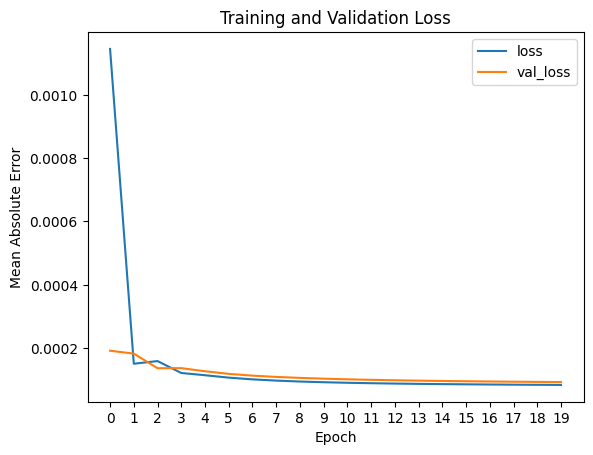

In [11]:
rnn_loss_df = pd.DataFrame(rnn_history.history)
rnn_loss_df[['loss', 'val_loss']].plot(legend=True)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.xticks(range(20))
plt.show()

### 9. Train an LSTM model and report the Test MAE. Feel free to pick any architecture but you could also use the RNN architecture above.

In [12]:
inputs = Input(shape=(sequence_length, 1))
x = LSTM(64, return_sequences=False)(inputs)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
lstm_history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[ModelCheckpoint("LSTM.keras", save_best_only=True)])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3688e-04 - mae: 0.0085 - val_loss: 9.9215e-05 - val_mae: 0.0080
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5482e-05 - mae: 0.0070 - val_loss: 1.0344e-04 - val_mae: 0.0082
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5529e-05 - mae: 0.0070 - val_loss: 1.0204e-04 - val_mae: 0.0082
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4348e-05 - mae: 0.0069 - val_loss: 1.0074e-04 - val_mae: 0.0081
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3233e-05 - mae: 0.0068 - val_loss: 9.9578e-05 - val_mae: 0.0081
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2213e-05 - mae: 0.0068 - val_loss: 9.8522e-05 - val_mae: 0.0080
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1276e-05 - mae: 0.0067 - val_loss: 9.7558e-05 - val_mae: 0.0080
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0411e-05 - mae: 0.0067 - val_loss: 9.6676e-05 - val_mae: 0.0079
Epoch 9

In [13]:
lstm_model = load_model("LSTM.keras")
print(f"Test MAE: {lstm_model.evaluate(test_dataset)[1]:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0007e-05 - mae: 0.0073  
Test MAE: 0.007


### 10. Using the LSTM model, plot the MAE vs epoch for train and validation set.

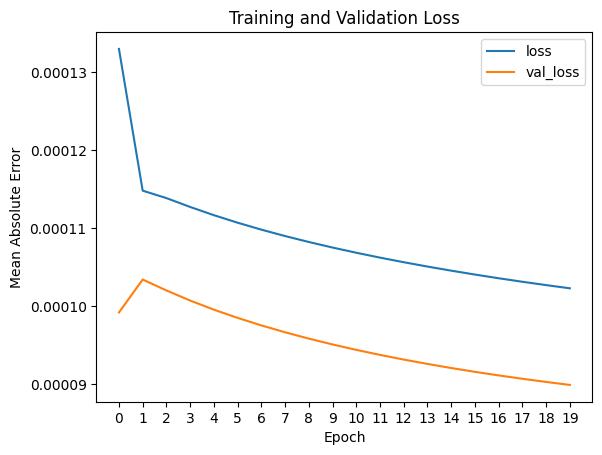

In [14]:
lstm_loss_df = pd.DataFrame(lstm_history.history)
lstm_loss_df[['loss', 'val_loss']].plot(legend=True)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.xticks(range(20))
plt.show()

### 11. Train the following more complex model:

1. Two recurrent layers stacked on top of each other:
    
    a. LSTM with 128 nodes and recurrent_dropout=0.1
    
    b. SimpleRNN with 128 nodes and recurrent_dropout=0.1
    
    c. Dropout(0.1)
2. Use callback= ModelCheckpoint
3. epochs = 20 
4. Use loss="mse"
5. keep track of MAE metric

In [15]:
inputs = Input(shape=(sequence_length, 1))
x = LSTM(32, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = SimpleRNN(128, recurrent_dropout=0.1)(x)
x = Dropout(0.1)(x)

outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
complex_history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[ModelCheckpoint("Complex.keras", save_best_only=True)])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0302 - mae: 0.1124 - val_loss: 8.0078e-05 - val_mae: 0.0069
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - mae: 0.0232 - val_loss: 1.7712e-04 - val_mae: 0.0114
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1131e-04 - mae: 0.0126 - val_loss: 9.2789e-05 - val_mae: 0.0077
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9997e-04 - mae: 0.0099 - val_loss: 8.4900e-05 - val_mae: 0.0073
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7464e-04 - mae: 0.0099 - val_loss: 1.1380e-04 - val_mae: 0.0083
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4906e-04 - mae: 0.0091 - val_loss: 8.0469e-05 - val_mae: 0.0069
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2417e-04 - mae: 0.0084 - val_loss: 7.7412e-05 - val_mae: 0.0068
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3020e-04 - mae: 0.0086 - val_loss: 9.1997e-05 - val_mae: 0.0077
Epoch 9/

In [16]:
complex_model = load_model("Complex.keras")
print(f"Test MAE: {complex_model.evaluate(test_dataset)[1]:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5558e-05 - mae: 0.0064  
Test MAE: 0.006


### 12. Using the stacked complex model, plot the MAE vs epoch for train and validation set.

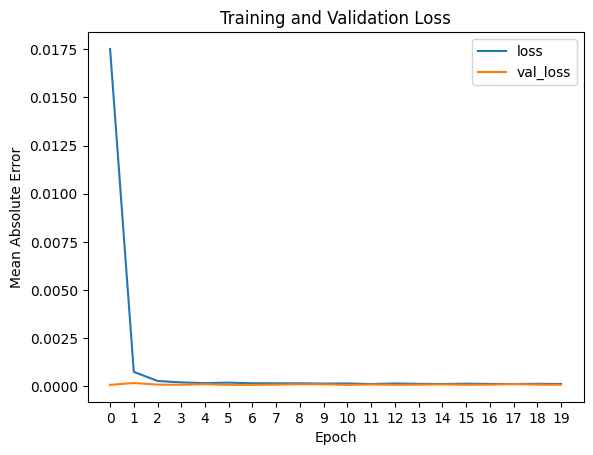

In [17]:
complex_loss_df = pd.DataFrame(complex_history.history)
complex_loss_df[['loss', 'val_loss']].plot(legend=True)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.xticks(range(20))
plt.show()

### 13. Which model is the winner? naive, RNN, LSTM or stacked?

In [18]:
print(f"Naive MAE: {evaluate_naive_method(test_dataset):.4f}")
print(f"RNN MAE: {rnn_model.evaluate(test_dataset)[1]:.4f}")
print(f"LSTM MAE: {lstm_model.evaluate(test_dataset)[1]:.4f}")
print(f"Complex MAE: {complex_model.evaluate(test_dataset)[1]:.4f}")

Naive MAE: 0.0083
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5535e-05 - mae: 0.0074 
RNN MAE: 0.0068
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0007e-05 - mae: 0.0073 
LSTM MAE: 0.0068
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5558e-05 - mae: 0.0064 
Complex MAE: 0.0059


13. (Answer) - The winner is the Complex Stacked model, with a MAE of `0.0059`, compared to the RNN and LSTM MAE of `0.0068` and the Naive MAE of `0.0083`.